#### The following code is adapted from the following tutorial 

https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

### Setup your environment

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1, l2

print(tf.__version__)

2.2.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num CPUs Available:  1


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

import pathlib
import shutil
import tempfile

In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

#### Helper Functions

#### That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [7]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

# https://www.tensorflow.org/tutorials/text/transformer
### A transformer model handles variable-sized input using stacks of self-attention layers instead of RNNs or CNNs.

### https://arxiv.org/abs/1706.03762

### https://www.tensorflow.org/api_docs/python/tf/clip_by_value

### we want to set our learning rates to these parameters based on the step
##### credit to this code is from https://github.com/ngupta23/ds7333_qtw/blob/master/case_study_6/analysis/master/cs6.ipynb

In [8]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self):
    super(CustomSchedule, self).__init__()
    
  def __call__(self, step):
    lr = tf.clip_by_value(0.05 / 1.0000002**step, clip_value_min=0.000001, clip_value_max=0.05)
    return lr

### Define the optimizer based on the learner schedule. 
### Paper uses SGD
### https://github.com/uci-igb/higgs-susy/blob/master/higgs/layers4_width300_lr005_m200_wd000001_all.py
### https://www.researchgate.net/publication/263704884_Searching_for_Exotic_Particles_in_High-Energy_Physics_with_Deep_Learning

In [9]:
def get_optimizer():
  lr_schedule = CustomSchedule()
  return tf.keras.optimizers.SGD(lr_schedule, momentum=0.9)

#### Next include callbacks.EarlyStopping to avoid long and unnecessary training times. Note that this callback is set to monitor the val_binary_crossentropy, not the val_loss. This difference will be important later.
#### Use callbacks.TensorBoard to generate TensorBoard logs for the training.

In [10]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', min_delta=0.00001, patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [11]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.AUC(name='AUC'),
                  tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=2)
  return history

## Dataset download, otherwise use local copy

In [12]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')

### Each example has 28 features, there are 11000000 examples

In [13]:
FEATURES = 28

### This should be used to read the csv directly unpacking from the gzip file without unpacking

In [14]:
ds = tf.data.experimental.CsvDataset( gz,[float(),]*(FEATURES+1), compression_type="GZIP")

### working in batches of 10000 use the map function to following function repacks that list of scalars into a (feature_vector, label) pair.

In [15]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

### Have a look at some of the records from this new packed_ds. The features are not perfectly normalized, but this is sufficient for this tutorial.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


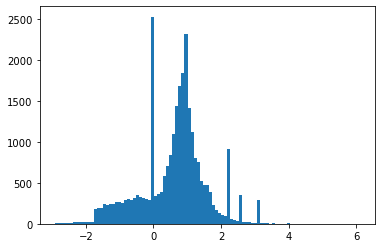

In [16]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

#### This is what 1 observation looks like. 

In [17]:
print(list(ds.take(2).as_numpy_iterator())[0])
print(list(ds.take(2).as_numpy_iterator())[1])

(1.0, 0.8692932, -0.6350818, 0.22569026, 0.32747006, -0.6899932, 0.75420225, -0.24857314, -1.0920639, 0.0, 1.3749921, -0.6536742, 0.9303491, 1.1074361, 1.1389043, -1.5781983, -1.0469854, 0.0, 0.65792954, -0.01045457, -0.04576717, 3.1019614, 1.35376, 0.9795631, 0.97807616, 0.92000484, 0.72165745, 0.98875093, 0.87667835)
(1.0, 0.9075421, 0.32914728, 0.35941187, 1.4979699, -0.31300953, 1.0955306, -0.5575249, -1.5882298, 2.1730762, 0.8125812, -0.21364193, 1.2710146, 2.2148721, 0.49999395, -1.2614318, 0.73215616, 0.0, 0.3987009, -1.1389301, -0.0008191102, 0.0, 0.3022199, 0.83304816, 0.98569965, 0.9780984, 0.77973217, 0.99235576, 0.7983426)


In [18]:
featVals=[features.numpy()[0] for features,label in packed_ds.take(1000)]

t=packed_ds.take(20000)

In [19]:
t = [label.numpy() for features,label in packed_ds.take(20000)]
print("Values 1:",sum(t))
print("Values 0:",sum(np.equal(t,0)))

Values 1: 10457.0
Values 0: 9543


In [20]:
t = np.array([features.numpy() for features,label in packed_ds.take(20000)])
print("Min Value:",min(t.flatten()))
print("Max Value:",max(t.flatten()))

Min Value: -2.960813
Max Value: 16.131908


### TODO: Note that the paper used 100, we can increase this to reduce training time.

In [21]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500  
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

### At the same time, use the Dataset.cache method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [22]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [23]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [24]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [25]:
tf.range(25, dtype=tf.float32)

<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.],
      dtype=float32)>

Text(0.5, 0, 'Train Step')

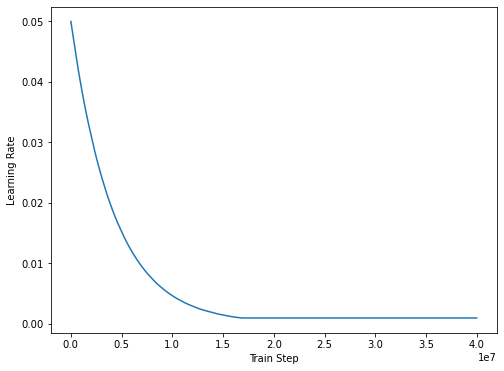

In [26]:
temp_lr_schedule = CustomSchedule()
plt.figure(figsize = (8,6))
lrs = temp_lr_schedule(tf.range(40000000, dtype=tf.float32))
plt.plot(lrs)
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [27]:
lrs

<tf.Tensor: shape=(40000000,), dtype=float32, numpy=
array([0.05      , 0.04999999, 0.04999998, ..., 0.00091578, 0.00091578,
       0.00091578], dtype=float32)>

In [28]:
size_histories = {}

##  Paper: https://archive.ics.uci.edu/ml/datasets/HIGGS
### https://github.com/uci-igb/higgs-susy/blob/master/higgs/layers4_width300_lr005_m200_wd000001_all.py
### https://www.tensorflow.org/api_docs/python/tf/keras/initializers/RandomNormal

#### Basically this tells our models where to initialize for each layer in the deep learning model

In [29]:

first_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1, seed=42)
outer_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.001, seed=42)
other_initializers = tf.keras.initializers.RandomNormal(mean=0., stddev=0.05, seed=42)


weight_decay=0.00001
paper_model = tf.keras.Sequential([
    layers.Dense(300, activation='tanh', input_shape=(FEATURES,), kernel_initializer=first_initializer, kernel_regularizer=l2(weight_decay)),
    layers.Dense(300, activation='tanh', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    #layers.Dropout(0.5), 
    layers.Dense(300, activation='tanh', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    layers.Dense(300, activation='tanh', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    layers.Dropout(0.5), 
    layers.Dense(1, activation='sigmoid', kernel_initializer=outer_initializer, kernel_regularizer=l2(weight_decay))
    
])

## Paper Model Architecture 

In [30]:
size_histories['paper'] = compile_and_fit(paper_model, 'sizes/paper')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               8700      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 301       
Total params: 279,901
Trainable params: 279,901
Non-trainable params: 0
__________________________________________________

Epoch 36/10000
.20/20 - 0s - loss: 0.6729 - AUC: 0.6543 - binary_crossentropy: 0.6653 - accuracy: 0.5868 - val_loss: 0.6712 - val_AUC: 0.6513 - val_binary_crossentropy: 0.6637 - val_accuracy: 0.5770
Epoch 37/10000
.20/20 - 0s - loss: 0.6725 - AUC: 0.6553 - binary_crossentropy: 0.6650 - accuracy: 0.5884 - val_loss: 0.6731 - val_AUC: 0.6413 - val_binary_crossentropy: 0.6656 - val_accuracy: 0.5580
Epoch 38/10000
.20/20 - 0s - loss: 0.6723 - AUC: 0.6537 - binary_crossentropy: 0.6648 - accuracy: 0.5871 - val_loss: 0.6722 - val_AUC: 0.6457 - val_binary_crossentropy: 0.6646 - val_accuracy: 0.5660
Epoch 39/10000
.20/20 - 0s - loss: 0.6717 - AUC: 0.6533 - binary_crossentropy: 0.6642 - accuracy: 0.5892 - val_loss: 0.6716 - val_AUC: 0.6467 - val_binary_crossentropy: 0.6641 - val_accuracy: 0.5700
Epoch 40/10000
.20/20 - 0s - loss: 0.6714 - AUC: 0.6574 - binary_crossentropy: 0.6638 - accuracy: 0.5961 - val_loss: 0.6709 - val_AUC: 0.6506 - val_binary_crossentropy: 0.6634 - val_accuracy: 0.5770
Epoch

Epoch 78/10000
.20/20 - 0s - loss: 0.6623 - AUC: 0.6859 - binary_crossentropy: 0.6548 - accuracy: 0.6246 - val_loss: 0.6624 - val_AUC: 0.6681 - val_binary_crossentropy: 0.6549 - val_accuracy: 0.5880
Epoch 79/10000
.20/20 - 0s - loss: 0.6629 - AUC: 0.6803 - binary_crossentropy: 0.6553 - accuracy: 0.6160 - val_loss: 0.6705 - val_AUC: 0.6532 - val_binary_crossentropy: 0.6630 - val_accuracy: 0.5590
Epoch 80/10000
.20/20 - 0s - loss: 0.6640 - AUC: 0.6790 - binary_crossentropy: 0.6564 - accuracy: 0.6205 - val_loss: 0.6651 - val_AUC: 0.6680 - val_binary_crossentropy: 0.6576 - val_accuracy: 0.5900
Epoch 81/10000
.20/20 - 0s - loss: 0.6640 - AUC: 0.6795 - binary_crossentropy: 0.6565 - accuracy: 0.6165 - val_loss: 0.6642 - val_AUC: 0.6799 - val_binary_crossentropy: 0.6567 - val_accuracy: 0.6200
Epoch 82/10000
.20/20 - 0s - loss: 0.6616 - AUC: 0.6877 - binary_crossentropy: 0.6541 - accuracy: 0.6226 - val_loss: 0.6633 - val_AUC: 0.6761 - val_binary_crossentropy: 0.6558 - val_accuracy: 0.6100
Epoch

Epoch 119/10000
.20/20 - 0s - loss: 0.6530 - AUC: 0.7088 - binary_crossentropy: 0.6454 - accuracy: 0.6508 - val_loss: 0.6570 - val_AUC: 0.7039 - val_binary_crossentropy: 0.6494 - val_accuracy: 0.6410
Epoch 120/10000
.20/20 - 0s - loss: 0.6522 - AUC: 0.7064 - binary_crossentropy: 0.6446 - accuracy: 0.6495 - val_loss: 0.6613 - val_AUC: 0.6988 - val_binary_crossentropy: 0.6537 - val_accuracy: 0.6540
Epoch 121/10000
.20/20 - 0s - loss: 0.6519 - AUC: 0.7056 - binary_crossentropy: 0.6443 - accuracy: 0.6522 - val_loss: 0.6569 - val_AUC: 0.6907 - val_binary_crossentropy: 0.6493 - val_accuracy: 0.6290
Epoch 122/10000
.20/20 - 0s - loss: 0.6490 - AUC: 0.7128 - binary_crossentropy: 0.6414 - accuracy: 0.6582 - val_loss: 0.6558 - val_AUC: 0.6923 - val_binary_crossentropy: 0.6482 - val_accuracy: 0.6270
Epoch 123/10000
.20/20 - 0s - loss: 0.6497 - AUC: 0.7153 - binary_crossentropy: 0.6421 - accuracy: 0.6609 - val_loss: 0.6641 - val_AUC: 0.6690 - val_binary_crossentropy: 0.6565 - val_accuracy: 0.5760


Epoch 160/10000
.20/20 - 0s - loss: 0.6411 - AUC: 0.7251 - binary_crossentropy: 0.6334 - accuracy: 0.6755 - val_loss: 0.6640 - val_AUC: 0.6872 - val_binary_crossentropy: 0.6562 - val_accuracy: 0.6400
Epoch 161/10000
.20/20 - 0s - loss: 0.6424 - AUC: 0.7271 - binary_crossentropy: 0.6346 - accuracy: 0.6813 - val_loss: 0.6507 - val_AUC: 0.6910 - val_binary_crossentropy: 0.6430 - val_accuracy: 0.6430
Epoch 162/10000
.20/20 - 0s - loss: 0.6399 - AUC: 0.7272 - binary_crossentropy: 0.6321 - accuracy: 0.6842 - val_loss: 0.6570 - val_AUC: 0.6922 - val_binary_crossentropy: 0.6493 - val_accuracy: 0.6420
Epoch 163/10000
.20/20 - 0s - loss: 0.6397 - AUC: 0.7297 - binary_crossentropy: 0.6320 - accuracy: 0.6857 - val_loss: 0.6535 - val_AUC: 0.6792 - val_binary_crossentropy: 0.6458 - val_accuracy: 0.6210
Epoch 164/10000
.20/20 - 0s - loss: 0.6425 - AUC: 0.7226 - binary_crossentropy: 0.6347 - accuracy: 0.6817 - val_loss: 0.6599 - val_AUC: 0.7030 - val_binary_crossentropy: 0.6522 - val_accuracy: 0.6760


Epoch 201/10000

Epoch: 200, AUC:0.7387,  accuracy:0.6958,  binary_crossentropy:0.6268,  loss:0.6347,  val_AUC:0.6580,  val_accuracy:0.5970,  val_binary_crossentropy:0.6549,  val_loss:0.6627,  
.20/20 - 0s - loss: 0.6347 - AUC: 0.7387 - binary_crossentropy: 0.6268 - accuracy: 0.6958 - val_loss: 0.6627 - val_AUC: 0.6580 - val_binary_crossentropy: 0.6549 - val_accuracy: 0.5970
Epoch 202/10000
.20/20 - 0s - loss: 0.6396 - AUC: 0.7232 - binary_crossentropy: 0.6318 - accuracy: 0.6797 - val_loss: 0.6560 - val_AUC: 0.6889 - val_binary_crossentropy: 0.6481 - val_accuracy: 0.6400
Epoch 203/10000
.20/20 - 0s - loss: 0.6368 - AUC: 0.7289 - binary_crossentropy: 0.6289 - accuracy: 0.6936 - val_loss: 0.6539 - val_AUC: 0.6865 - val_binary_crossentropy: 0.6460 - val_accuracy: 0.6570
Epoch 204/10000
.20/20 - 0s - loss: 0.6307 - AUC: 0.7436 - binary_crossentropy: 0.6228 - accuracy: 0.7044 - val_loss: 0.6598 - val_AUC: 0.6937 - val_binary_crossentropy: 0.6519 - val_accuracy: 0.6590
Epoch 205/10000
.20/20

.20/20 - 0s - loss: 0.6271 - AUC: 0.7453 - binary_crossentropy: 0.6190 - accuracy: 0.7096 - val_loss: 0.6549 - val_AUC: 0.6830 - val_binary_crossentropy: 0.6469 - val_accuracy: 0.6400
Epoch 242/10000
.20/20 - 0s - loss: 0.6254 - AUC: 0.7499 - binary_crossentropy: 0.6173 - accuracy: 0.7159 - val_loss: 0.6559 - val_AUC: 0.6751 - val_binary_crossentropy: 0.6479 - val_accuracy: 0.6300
Epoch 243/10000
.20/20 - 0s - loss: 0.6304 - AUC: 0.7417 - binary_crossentropy: 0.6224 - accuracy: 0.7073 - val_loss: 0.6632 - val_AUC: 0.6406 - val_binary_crossentropy: 0.6551 - val_accuracy: 0.5920
Epoch 244/10000
.20/20 - 0s - loss: 0.6268 - AUC: 0.7473 - binary_crossentropy: 0.6188 - accuracy: 0.7143 - val_loss: 0.6617 - val_AUC: 0.6752 - val_binary_crossentropy: 0.6537 - val_accuracy: 0.6310
Epoch 245/10000
.20/20 - 0s - loss: 0.6279 - AUC: 0.7500 - binary_crossentropy: 0.6198 - accuracy: 0.7108 - val_loss: 0.6621 - val_AUC: 0.6630 - val_binary_crossentropy: 0.6541 - val_accuracy: 0.6080
Epoch 246/10000


.20/20 - 0s - loss: 0.6411 - AUC: 0.7095 - binary_crossentropy: 0.6329 - accuracy: 0.6730 - val_loss: 0.6650 - val_AUC: 0.6595 - val_binary_crossentropy: 0.6567 - val_accuracy: 0.6260
Epoch 283/10000
.20/20 - 0s - loss: 0.6217 - AUC: 0.7560 - binary_crossentropy: 0.6135 - accuracy: 0.7249 - val_loss: 0.6609 - val_AUC: 0.6790 - val_binary_crossentropy: 0.6527 - val_accuracy: 0.6520
Epoch 284/10000
.20/20 - 0s - loss: 0.6176 - AUC: 0.7638 - binary_crossentropy: 0.6094 - accuracy: 0.7334 - val_loss: 0.6638 - val_AUC: 0.6524 - val_binary_crossentropy: 0.6555 - val_accuracy: 0.6120
Epoch 285/10000
.20/20 - 0s - loss: 0.6186 - AUC: 0.7630 - binary_crossentropy: 0.6104 - accuracy: 0.7324 - val_loss: 0.6619 - val_AUC: 0.6557 - val_binary_crossentropy: 0.6537 - val_accuracy: 0.6180
Epoch 286/10000
.20/20 - 0s - loss: 0.6188 - AUC: 0.7617 - binary_crossentropy: 0.6105 - accuracy: 0.7313 - val_loss: 0.6614 - val_AUC: 0.6575 - val_binary_crossentropy: 0.6531 - val_accuracy: 0.6250
Epoch 287/10000


Epoch 323/10000
.20/20 - 0s - loss: 0.6203 - AUC: 0.7583 - binary_crossentropy: 0.6119 - accuracy: 0.7293 - val_loss: 0.6645 - val_AUC: 0.6391 - val_binary_crossentropy: 0.6561 - val_accuracy: 0.6070
Epoch 324/10000
.20/20 - 0s - loss: 0.6224 - AUC: 0.7552 - binary_crossentropy: 0.6140 - accuracy: 0.7243 - val_loss: 0.6677 - val_AUC: 0.6544 - val_binary_crossentropy: 0.6593 - val_accuracy: 0.6240
Epoch 325/10000
.20/20 - 0s - loss: 0.6143 - AUC: 0.7676 - binary_crossentropy: 0.6059 - accuracy: 0.7409 - val_loss: 0.6588 - val_AUC: 0.6759 - val_binary_crossentropy: 0.6503 - val_accuracy: 0.6530
Epoch 326/10000
.20/20 - 0s - loss: 0.6123 - AUC: 0.7740 - binary_crossentropy: 0.6039 - accuracy: 0.7489 - val_loss: 0.6638 - val_AUC: 0.6560 - val_binary_crossentropy: 0.6554 - val_accuracy: 0.6270
Epoch 327/10000
.20/20 - 0s - loss: 0.6128 - AUC: 0.7724 - binary_crossentropy: 0.6043 - accuracy: 0.7513 - val_loss: 0.6642 - val_AUC: 0.6506 - val_binary_crossentropy: 0.6558 - val_accuracy: 0.6180


In [31]:
size_histories['paper'].history['AUC'][0:10]

[0.5129669308662415,
 0.5102459788322449,
 0.5463467240333557,
 0.5596256852149963,
 0.5665290951728821,
 0.5807941555976868,
 0.5873706936836243,
 0.5948611497879028,
 0.6039280891418457,
 0.6166744828224182]

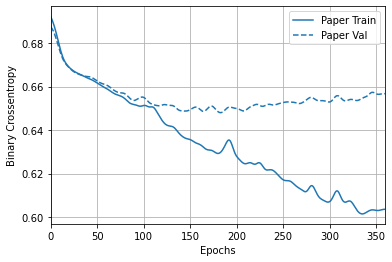

In [32]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)

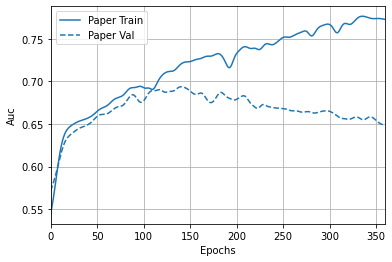

In [33]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'AUC', smoothing_std=10)
plotter.plot(size_histories)

Text(0.5, 0, 'Epochs [Log Scale]')

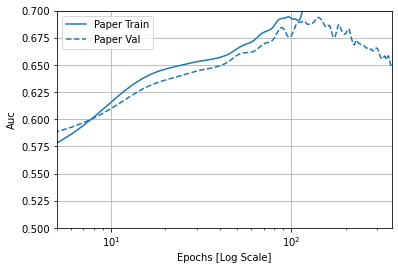

In [34]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [35]:
%tensorboard --logdir {logdir}/sizes

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")